In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline


In [2]:
def next_batch(index, batch_size,total,data,labels):
    """Return the next `batch_size` examples from this data set."""
    start = index
    end = index+batch_size if index+batch_size<= total else None
    return data[start:end], labels[start:end]

In [3]:
def plot_gallery(title, images, n_col, n_row,image_shape = (28, 28)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()   

In [4]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# read training data from CSV file 
dataTrain = pd.read_csv('./kaggle-mnist/train.csv')
images = dataTrain.iloc[:,1:].values
images = images.astype(np.float)
images = np.multiply(images, 1.0 / 255.0)

labels_flat = dataTrain[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [5]:
images.shape

(42000, 784)

In [6]:
labels.shape

(42000, 10)

In [7]:
# Parameters
learning_rate = 0.01
training_epochs = 2000
batch_size = 256
display_step = 100
examples_to_show = 10

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = images.shape[1] # MNIST data input (img shape: 28*28)


In [8]:

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

In [9]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [10]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

In [11]:
total_batch = int(images.shape[0]/batch_size)
total_batch

164

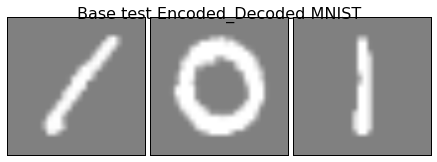

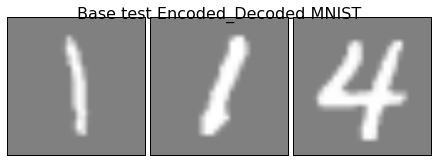

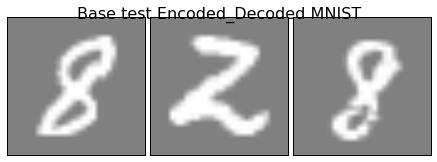

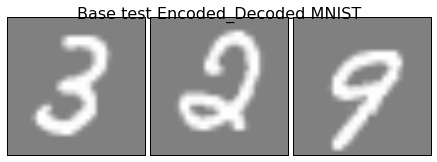

In [ ]:
for i in range(4):
    batch_xs, batch_ys = next_batch(i*batch_size, batch_size,images.shape[0],images,labels)
    plot_gallery('Base test Encoded_Decoded MNIST',batch_xs[:3],3,1)


In [ ]:
# Launch the graph
# Using InteractiveSession (more convenient while using Notebooks)
#tf.reset_default_graph()
sess = tf.InteractiveSession()
sess.run(init)

total_batch = int(images.shape[0]/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = next_batch(i*batch_size, batch_size,images.shape[0],images,labels)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

Epoch: 0001 cost= 0.263868183
Epoch: 0101 cost= 0.067487553


In [ ]:
# read test data from CSV file 
datatest = pd.read_csv('./kaggle-mnist/test.csv')
imagestest = datatest.iloc[:,:].values
imagestest = imagestest.astype(np.float)
imagestest = np.multiply(imagestest, 1.0 / 255.0)


In [ ]:
imagestest.shape

In [ ]:
# Applying encode and decode over test set
encode_decode = sess.run(
    y_pred, feed_dict={X: imagestest[:examples_to_show]})


In [ ]:
# Compare original images with their reconstructions
plot_gallery('Base test MNIST',imagestest[:examples_to_show],examples_to_show/2,2)
plot_gallery('Base test Encoded_Decoded MNIST',encode_decode[:examples_to_show],examples_to_show/2,2)


In [ ]:
x_sample, y_sample = next_batch(0, examples_to_show,images.shape[0],images,labels)
#z_mu = vae_2d.transform(x_sample)
# Applying encode and decode over test set
z_mu = sess.run(
    y_pred, feed_dict={X: imagestest[:examples_to_show]})
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.show()